# Predicting the total count of bikes per hour from 2011 to 2012
Objective: Predict the total count of bikes rented during each hour for the week commencing on 24th 
December 2012 (dataset contains the predictions for the independent variables like weather, temperature, 
humidity, windspeed etc.)

Approach: 
(1) We follow the TDSP (team data science process) and initially perform an initial investigation of the dataset (initial insights about the data are noted). Note: insights are discussed at the cell-block where the output is shown. 

(2) Following that we determine the feature ranking within the dataset and determine the top-ranked features. (possible extension: generate more features - will explore if time permits). 

(3) Build a baseline random forest regression model using all features

(4) Build a random forest regression model using the top features from step (2) and compare with baseline

(5) Perform hyper-parameter search and 5-fold cross-validation to determine the parameters of training model and build the training model using optimal parameters

(6) Apply the model on the test set and publish the test results


# Import the libraries

In [155]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeRegressor

import seaborn as sns
import matplotlib.pyplot as plt

In [105]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 30)

#sns.set_style("whitegrid")
#plt.style.use('bmh')
plt.style.use('seaborn-whitegrid')

# this allows plots to appear directly in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Read and construct the datasets

In [106]:
train_df = pd.read_csv('train.csv')
train_df['data_set'] = 'train'
train_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,data_set
0,1/01/2011 0:00,1,0,0,1,0.24,0.2879,0.81,0.0,16,train
1,1/01/2011 1:00,1,0,0,1,0.22,0.2727,0.80,0.0,40,train
2,1/01/2011 2:00,1,0,0,1,0.22,0.2727,0.80,0.0,32,train
3,1/01/2011 3:00,1,0,0,1,0.24,0.2879,0.75,0.0,13,train
4,1/01/2011 4:00,1,0,0,1,0.24,0.2879,0.75,0.0,1,train


In [107]:
test_df = pd.read_csv('test.csv')
test_df['data_set'] = 'test'
test_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,data_set
0,24/12/2012 0:00,1,0,1,1,0.22,0.2727,0.69,0.0000,test
1,24/12/2012 1:00,1,0,1,1,0.22,0.2727,0.69,0.0000,test
2,24/12/2012 2:00,1,0,1,1,0.20,0.2576,0.75,0.0000,test
3,24/12/2012 3:00,1,0,1,1,0.20,0.2576,0.75,0.0000,test
4,24/12/2012 5:00,1,0,1,1,0.18,0.1970,0.80,0.1343,test


In [45]:
# combine train and test data into one df
test_df['count'] = 0

all_df = pd.concat([train_df, test_df])
all_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,data_set
0,1/01/2011 0:00,1,0,0,1,0.24,0.2879,0.81,0.0,16,train
1,1/01/2011 1:00,1,0,0,1,0.22,0.2727,0.80,0.0,40,train
2,1/01/2011 2:00,1,0,0,1,0.22,0.2727,0.80,0.0,32,train
3,1/01/2011 3:00,1,0,0,1,0.24,0.2879,0.75,0.0,13,train
4,1/01/2011 4:00,1,0,0,1,0.24,0.2879,0.75,0.0,1,train


In [46]:
all_df.tail(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,data_set
161,30/12/2012 19:00,1,0,0,1,0.34,0.3636,0.61,0.0000,0,test
162,30/12/2012 20:00,1,0,0,1,0.22,0.1970,0.47,0.3284,0,test
163,30/12/2012 21:00,1,0,0,1,0.20,0.2121,0.51,0.1642,0,test
164,30/12/2012 22:00,1,0,0,1,0.20,0.1970,0.55,0.1940,0,test
165,30/12/2012 23:00,1,0,0,1,0.20,0.1970,0.51,0.2239,0,test


In [108]:
# lowercase column names
all_df.columns = map(str.lower, all_df.columns)
all_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count', 'data_set', 'count_log',
       'date', 'day', 'month', 'year', 'hour', 'dow', 'woy'],
      dtype='object')

In [109]:
# parse datetime colum & add new time related columns
dt = pd.DatetimeIndex(all_df['datetime'])
all_df.set_index(dt, inplace=True)

In [49]:
all_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,data_set
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1/01/2011 0:00,1,0,0,1,0.24,0.2879,0.81,0.0,16,train
2011-01-01 01:00:00,1/01/2011 1:00,1,0,0,1,0.22,0.2727,0.80,0.0,40,train
2011-01-01 02:00:00,1/01/2011 2:00,1,0,0,1,0.22,0.2727,0.80,0.0,32,train
2011-01-01 03:00:00,1/01/2011 3:00,1,0,0,1,0.24,0.2879,0.75,0.0,13,train
2011-01-01 04:00:00,1/01/2011 4:00,1,0,0,1,0.24,0.2879,0.75,0.0,1,train


In [50]:
# Indexing by datetime let's us to select rows by specifying time ranges
all_df['2011-01-01 01:00:00':'2011-01-01 03:00:00']

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,data_set
datetime,,,,,,,,,,,
2011-01-01 01:00:00,1/01/2011 1:00,1,0,0,1,0.22,0.2727,0.80,0.0,40,train
2011-01-01 02:00:00,1/01/2011 2:00,1,0,0,1,0.22,0.2727,0.80,0.0,32,train
2011-01-01 03:00:00,1/01/2011 3:00,1,0,0,1,0.24,0.2879,0.75,0.0,13,train


# Performing Exploratory Data Analysis (EDA)

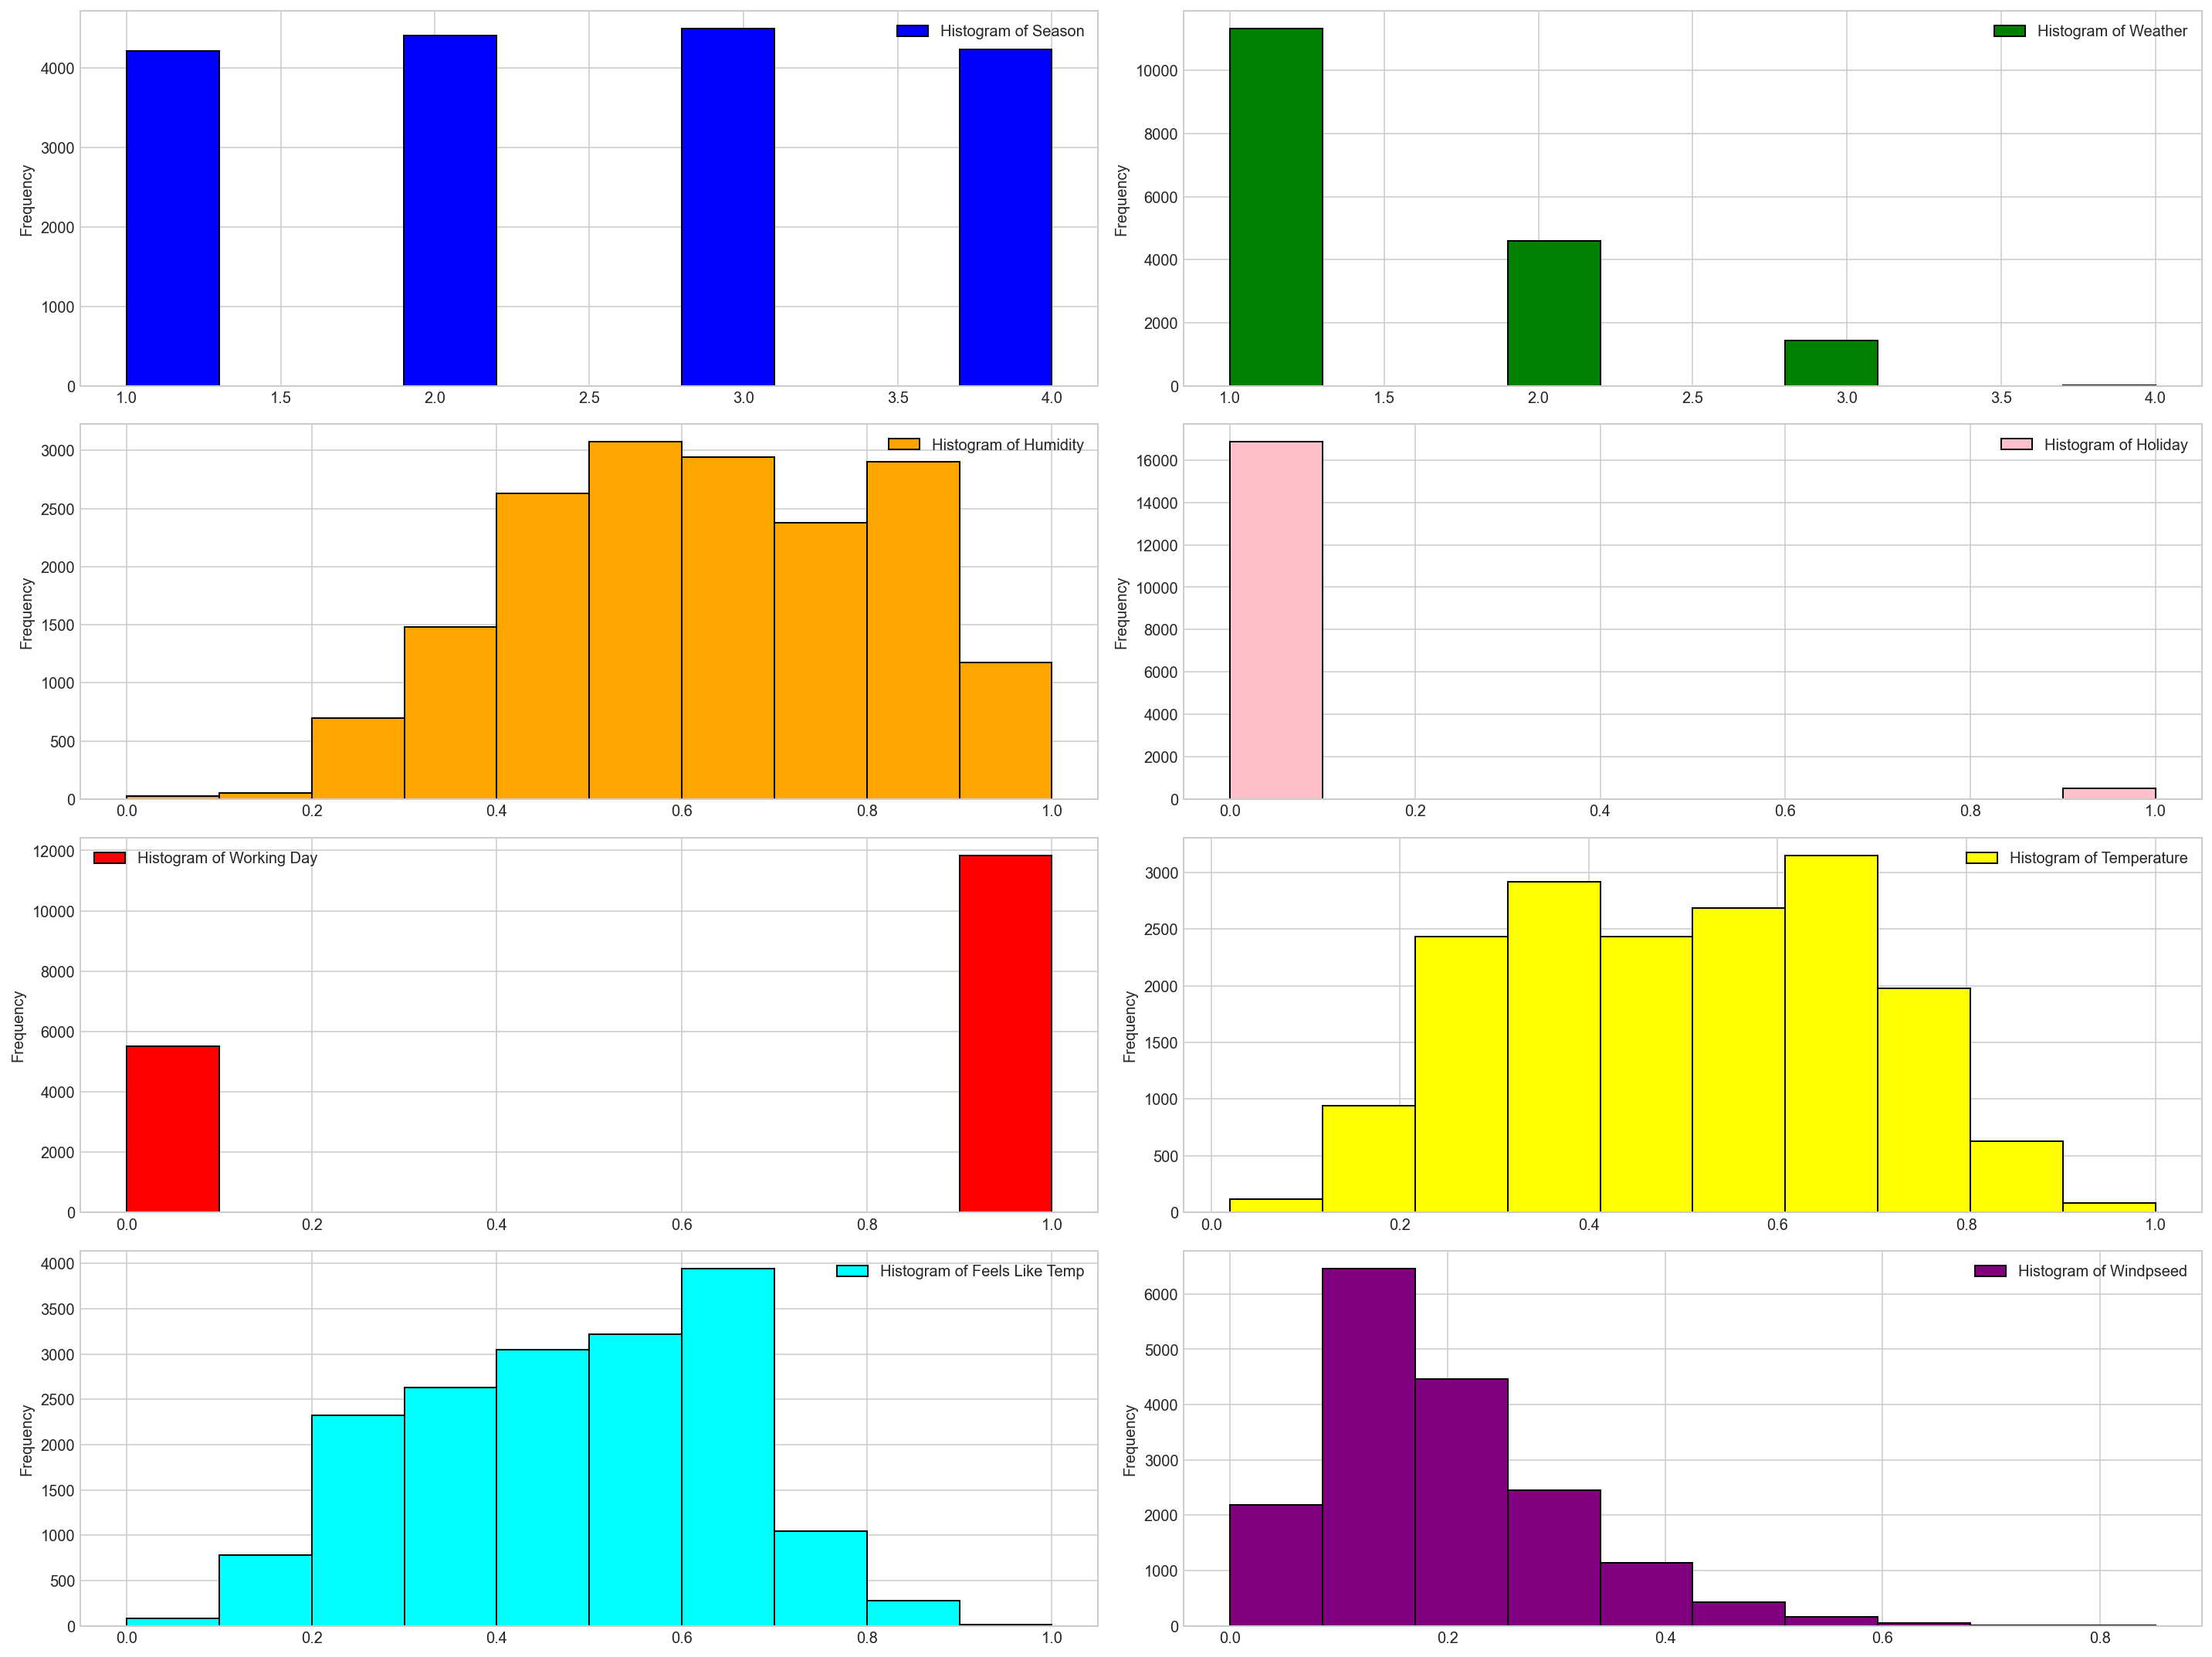

In [66]:
plt.figure(figsize=(20,15))
plt.subplot(421)
all_df['season'].plot.hist(bins=10, color='blue', label='Histogram of Season', edgecolor='black')
plt.legend(loc='best')
plt.subplot(422)
all_df['weather'].plot.hist(bins=10, color='green', label='Histogram of Weather', edgecolor='black')
plt.legend(loc='best')
plt.subplot(423)
all_df['humidity'].plot.hist(bins=10, color='orange', label='Histogram of Humidity', edgecolor='black')
plt.legend(loc='best')
plt.subplot(424)
all_df['holiday'].plot.hist(bins=10, color='pink', label='Histogram of Holiday', edgecolor='black')
plt.legend(loc='best')
plt.subplot(425)
all_df['workingday'].plot.hist(bins=10, color='red', label='Histogram of Working Day', edgecolor='black')
plt.legend(loc='best')
plt.subplot(426)
all_df['temp'].plot.hist(bins=10, color='yellow', label='Histogram of Temperature', edgecolor='black')
plt.legend(loc='best')
plt.subplot(427)
all_df['atemp'].plot.hist(bins=10, color='cyan', label='Histogram of Feels Like Temp', edgecolor='black')
plt.legend(loc='best')
plt.subplot(428)
all_df['windspeed'].plot.hist(bins=10, color='purple', label='Histogram of Windpseed', edgecolor='black')
plt.legend(loc='best')
plt.tight_layout();

In [92]:
(rows_total, cols_total) = all_df.shape
(rows_temp_1, cols_temp_1) = all_df[ all_df['weather'] == 1 ].shape
(rows_temp_4, cols_temp_4) = all_df[ all_df['weather'] == 4 ].shape
(rows_temp_5, cols_temp_5) = all_df[ all_df['holiday'] == 0 ].shape
(rows_temp_6, cols_temp_6) = all_df[ all_df['windspeed'] <= 0.3 ].shape
print("Perecentage of records where weather = 1:", rows_temp_1/rows_total)
print("Perecentage of records where weather = 4:", rows_temp_4/rows_total, "and number of records are-", rows_temp_4)
print("Perecentage of records where holiday = 0:", rows_temp_5/rows_total)
print("Perecentage of records where windspeed<=0.3:", rows_temp_6/rows_total)

Perecentage of records where weather = 1: 0.6530106597522328
Perecentage of records where weather = 4: 0.0006338231057332181 and number of records are- 11
Perecentage of records where holiday = 0: 0.9711898588303083
Perecentage of records where windspeed<=0.3: 0.8615384615384616


# Key Insight 1: Weather data is skewed.
1. 65% of times the weather has been "Clear, Few clouds, Partly cloudy". This is majority of records.   
2. The data indicates that with only 11 records, percentage of weather with "Heavy Rain + Hail + Thunderstorm + Mist, Snow + Fog" is extremely negligible. 

# Key Insight 2: Holiday data is skewed
97% of records are for weekdays.

# Key Insight 3: Windspeed is skewed.
86% of records show days with low windspeed (<0.3 on normalised data indicates that the original windspeed must have been low).

Overall: At a qualitative level, the data distribution mainly focusses on clear weekdays with low windspeed. Thus, while modeling would provide good approximations for clear weekdays, bike rentals prediction outside of these constraints can be trickier to predict (this also points to the closed-world assumption within datasets). Ideally, imbalanced data issues can be addressed using data augmentation techniques - oversampling, labeling new seeds, synthetic simulations etc.


In [52]:
# logarithmic transformation of dependent cols
# (adding 1 first so that 0 values don't become -inf)
for col in ['count']:
    all_df['%s_log' % col] = np.log(all_df[col] + 1)

In [53]:
all_df['date'] = dt.date
all_df['day'] = dt.day
all_df['month'] = dt.month
all_df['year'] = dt.year
all_df['hour'] = dt.hour
all_df['dow'] = dt.dayofweek
all_df['woy'] = dt.weekofyear

C:\Users\Shameek\AppData\Local\Temp\ipykernel_16280\944767597.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  all_df['woy'] = dt.weekofyear


In [54]:
all_df.isnull().sum()

datetime       0
season         0
holiday        0
workingday     0
weather        0
temp           0
atemp          0
humidity      10
windspeed      0
count          0
data_set       0
count_log      0
date           0
day            0
month          0
year           0
hour           0
dow            0
woy            0
dtype: int64

In [58]:
all_df[all_df['humidity'].isnull()]['humidity'] 

datetime
2011-01-01 14:00:00   NaN
2011-03-01 11:00:00   NaN
2011-05-01 01:00:00   NaN
2011-08-01 05:00:00   NaN
2011-04-02 05:00:00   NaN
2011-01-06 07:00:00   NaN
2012-07-01 08:00:00   NaN
2012-05-07 03:00:00   NaN
2012-02-11 04:00:00   NaN
2012-11-25 11:00:00   NaN
Name: humidity, dtype: float64

# Find missing values and impute using column averaging measure 

In [57]:
# find missing values in dataset if any
all_df.isnull().values.sum()

10

In [59]:
print("The dates with missing humidity values are -", all_df[all_df['humidity'].isnull()]['humidity'])

The dates with missing humidity values are - datetime
2011-01-01 14:00:00   NaN
2011-03-01 11:00:00   NaN
2011-05-01 01:00:00   NaN
2011-08-01 05:00:00   NaN
2011-04-02 05:00:00   NaN
2011-01-06 07:00:00   NaN
2012-07-01 08:00:00   NaN
2012-05-07 03:00:00   NaN
2012-02-11 04:00:00   NaN
2012-11-25 11:00:00   NaN
Name: humidity, dtype: float64


In [60]:
# impute using column mean
humidity_mean = all_df['humidity'].mean()
all_df['humidity'] = all_df['humidity'].fillna(humidity_mean)
all_df.isnull().sum() #testing for null again to confirm

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
data_set      0
count_log     0
date          0
day           0
month         0
year          0
hour          0
dow           0
woy           0
dtype: int64

# Describe the datasets

In [118]:
train_df = all_df[all_df['data_set'] == 'train']
test_df = all_df[all_df['data_set'] == 'test']

# summarize the dataset
print("Training data dimesions =", train_df.shape)
print("Test data dimesnions =", test_df.shape)
train_df.head(5)

Training data dimesions = (17189, 19)
Test data dimesnions = (166, 19)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,data_set,count_log,date,day,month,year,hour,dow,woy
datetime,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1/01/2011 0:00,1,0,0,1,0.24,0.2879,0.81,0.0,16,train,2.833213,2011-01-01,1,1,2011,0,5,52
2011-01-01 01:00:00,1/01/2011 1:00,1,0,0,1,0.22,0.2727,0.80,0.0,40,train,3.713572,2011-01-01,1,1,2011,1,5,52
2011-01-01 02:00:00,1/01/2011 2:00,1,0,0,1,0.22,0.2727,0.80,0.0,32,train,3.496508,2011-01-01,1,1,2011,2,5,52
2011-01-01 03:00:00,1/01/2011 3:00,1,0,0,1,0.24,0.2879,0.75,0.0,13,train,2.639057,2011-01-01,1,1,2011,3,5,52
2011-01-01 04:00:00,1/01/2011 4:00,1,0,0,1,0.24,0.2879,0.75,0.0,1,train,0.693147,2011-01-01,1,1,2011,4,5,52


# Model training and parameter tuning 

In [126]:
X = train_df.drop(['count','date','datetime','data_set','count_log'], axis=1)
y = train_df['count']

X_test = test_df.drop(['count','date','datetime','data_set','count_log'], axis=1)

X.head(5)

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X, y);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
print("Test predictions are -", predictions)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,day,month,year,hour,dow,woy
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,0.24,0.2879,0.81,0.0,1,1,2011,0,5,52
2011-01-01 01:00:00,1,0,0,1,0.22,0.2727,0.80,0.0,1,1,2011,1,5,52
2011-01-01 02:00:00,1,0,0,1,0.22,0.2727,0.80,0.0,1,1,2011,2,5,52
2011-01-01 03:00:00,1,0,0,1,0.24,0.2879,0.75,0.0,1,1,2011,3,5,52
2011-01-01 04:00:00,1,0,0,1,0.24,0.2879,0.75,0.0,1,1,2011,4,5,52


RandomForestRegressor(n_estimators=1000, random_state=42)

Test predictions are - [ 21.187   8.73    4.503   3.002  18.901  75.419 257.076 474.086 238.766
 149.902 159.345 189.783 174.919 172.688 175.122 182.24  239.227 232.994
 209.142 143.202 104.278  96.551  50.918  36.949  28.881  23.14    7.202
   5.94    9.223  27.072  68.198  96.613 147.138 160.194 166.592 254.398
 248.413 216.668 219.583 169.459 158.607 134.39   93.56   82.893  76.844
  46.693  23.36    8.095   7.852   3.621   2.651  22.76   81.443 266.795
 455.015 215.208 149.318 145.108 169.312 175.003 166.938 195.925 203.421
 270.238 239.613 197.252 161.805 113.377  81.614  49.876  22.338   8.172
   7.423   3.098   3.006  21.992  85.052 263.684 519.585 244.152 171.384
 178.505 205.132 212.622 194.066 200.504 216.293 286.898 264.223 206.065
 141.536 102.402  75.767  50.684  23.89   10.015   6.824   3.69    2.986
  22.382  82.683 246.232 468.333 245.401 159.464 181.564 200.353 206.669
 201.11  194.849 234.888 261.793 251.673 202.077 134.684  99.061  77.557
  53.783  39.444  37.214  33

Text(0.5, 1.0, 'Feature Importance')

<BarContainer object of 14 artists>

([<matplotlib.axis.XTick at 0x207bb401840>,
 [Text(0, 0, 'hour'),
  Text(1, 0, 'temp'),
  Text(2, 0, 'year'),
  Text(3, 0, 'workingday'),
  Text(4, 0, 'humidity'),
  Text(5, 0, 'season'),
  Text(6, 0, 'atemp'),
  Text(7, 0, 'weather'),
  Text(8, 0, 'day'),
  Text(9, 0, 'woy'),
  Text(10, 0, 'windspeed'),
  Text(11, 0, 'dow'),
  Text(12, 0, 'month'),
  Text(13, 0, 'holiday')])

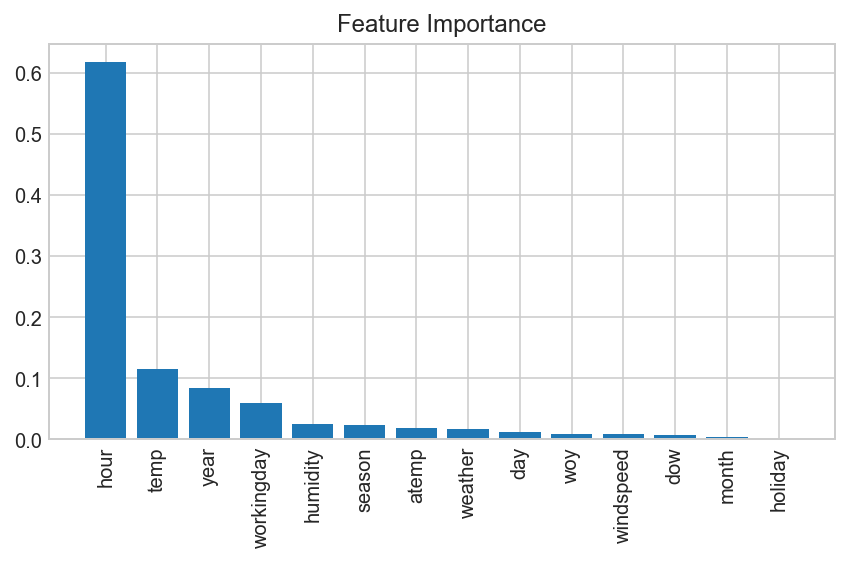

In [133]:
importances = rf.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

<AxesSubplot:>

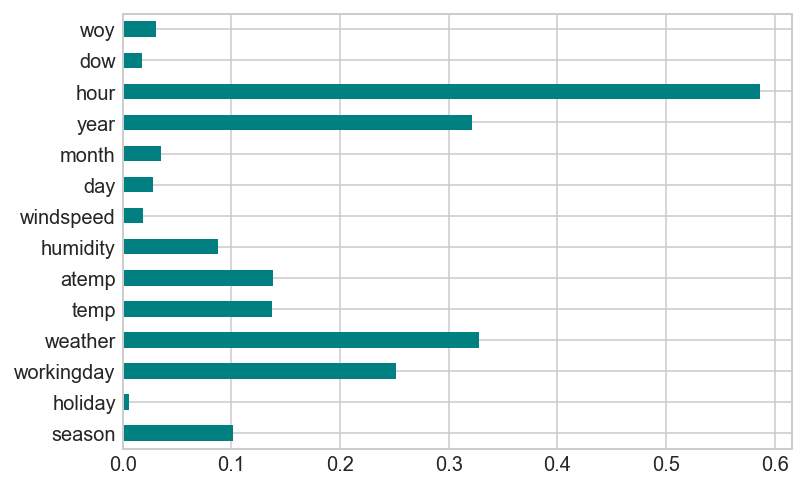

In [137]:
importances = mutual_info_classif(X,y)
feat_importances = pd.Series(importances, X.columns[0:len(X.columns)])
feat_importances.plot(kind='barh', color = 'teal')
plt.show()

DecisionTreeRegressor()

[0.02387951 0.00189923 0.06238408 0.0178029  0.11448585 0.01627287
 0.02351951 0.00864118 0.01125384 0.002356   0.08302456 0.61420781
 0.00885397 0.01141869]
Feature: 0, Score: 0.02388
Feature: 1, Score: 0.00190
Feature: 2, Score: 0.06238
Feature: 3, Score: 0.01780
Feature: 4, Score: 0.11449
Feature: 5, Score: 0.01627
Feature: 6, Score: 0.02352
Feature: 7, Score: 0.00864
Feature: 8, Score: 0.01125
Feature: 9, Score: 0.00236
Feature: 10, Score: 0.08302
Feature: 11, Score: 0.61421
Feature: 12, Score: 0.00885
Feature: 13, Score: 0.01142


<BarContainer object of 14 artists>

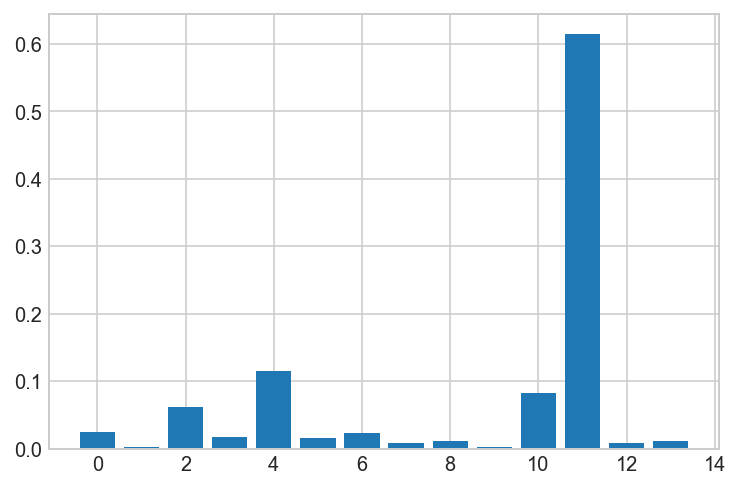

datetime
2011-01-01 00:00:00    0.24
2011-01-01 01:00:00    0.22
2011-01-01 02:00:00    0.22
2011-01-01 03:00:00    0.24
2011-01-01 04:00:00    0.24
                       ... 
2012-12-23 19:00:00    0.30
2012-12-23 20:00:00    0.26
2012-12-23 21:00:00    0.24
2012-12-23 22:00:00    0.24
2012-12-23 23:00:00    0.24
Name: temp, Length: 17189, dtype: float64


In [150]:
# define the model
dt = DecisionTreeRegressor()

# fit the model
dt.fit(X, y)

# get importance
importance = dt.feature_importances_

print(importance)

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

print(X.iloc[:,4])

In [87]:
# instead of randomly splitting our training data 
# for cross validation, let's construct a framework that's more
# in line with how the data is divvied up for this competition
# (given first 19 days of each month, what is demand for remaining days)
# so, let's split our training data into 2 time contiguous datasets
# for fitting and validating our model (days 1-14 vs. days 15-19).

# also, since submissions are evaluated based on the
# root mean squared logarithmic error (RMSLE), let's replicate
# that computation as we test and tune our model.

train_df = all_df[all_df['data_set'] == 'train']
test_df = all_df[all_df['data_set'] == 'test']

def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

def custom_train_valid_split(data, cutoff_day=15):
    train = data[data['day'] <= cutoff_day]
    valid = data[data['day'] > cutoff_day]

    return train, valid

def prep_train_data(data, input_cols):
    X = data[input_cols].values
    y_r = data['count'].values
 
    return X, y_r

# predict on validation set & transform output back from log scale
def predict_on_validation_set(model, input_cols):
    
    train, valid = custom_train_valid_split(train_df)

    # prepare training & validation set
    X_train, y_train_r = prep_train_data(train, input_cols)
    X_valid, y_valid_r = prep_train_data(valid, input_cols)

  
    model_r = model.fit(X_train, y_train_r)
    print(model_r)
    
    y_pred_r = model_r.predict(X_valid)

    return (y_pred_r)


# predict on test set & transform output back from log scale
def predict_on_test_set(model, input_cols):
    
    # prepare training set
    X_train, y_train_r= prep_train_data(train_df, input_cols)

    # prepare testing set
    X_test = test_df[input_cols].values
    
    model_r = model.fit(X_train, y_train_r)
    y_pred_r = model_r.predict(X_test)
    
    return y_pred_r

In [88]:
params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}
rf_model = RandomForestRegressor(**params)
rf_cols = [
    'weather', 'temp', 'atemp', 'windspeed',
    'workingday', 'season', 'holiday', 'hour', 'dow', 'woy'
    ]

(rf_pred) = predict_on_validation_set(rf_model, rf_cols)

RandomForestRegressor(max_depth=15, min_samples_split=5, n_estimators=1000,
                      n_jobs=-1, random_state=0)


In [89]:
print(rf_pred)

[38.05132775 38.50057234 33.9765869  ... 57.69235048 56.95407515
 49.00820109]


In [90]:
params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}
rf_model = RandomForestRegressor(**params)
rf_cols = [
    'weather', 'temp', 'atemp', 'windspeed',
    'workingday', 'season', 'holiday', 'hour', 'dow', 'woy'
    ]

(rf_pred) = predict_on_test_set(rf_model, rf_cols)

In [91]:
print(rf_pred)

[ 16.45641359   9.12953668   4.47041741   3.80709497  12.05580313
  50.87832555 170.31131248 343.09925333 197.38824621 138.5172782
 132.09765566 149.20285868 110.39705134 108.95895084 104.72705846
 111.74652711 200.62332971 196.97635279 152.53022025 104.32954427
  89.96493326  53.2575335   34.30249175  24.38888452  19.59156212
  17.03718936   3.36555812   4.83356547   6.71975234  23.34151521
  37.65953046  82.85691265 112.4915064  123.79337902 124.05452995
 167.92294832 140.83954389 122.94846783 121.64218598 100.74503075
  89.56646145  81.50402818  65.11704159  62.97482304  43.24055311
  37.0126319   18.76228264   8.14023239   8.86797494   3.53923277
   2.47981428  11.06885282  53.67837662 144.9000499  218.2711614
 132.74789244  49.57129547  50.13057707  60.16263017  59.96576255
  63.75220595 157.75635003 173.28106375 243.36198018 205.82493336
 148.03931475  84.82470443  65.74404251  58.41883338  38.32414163
  19.96194025   7.3261366    8.65400428   3.229824     2.93014639
  12.2080323